In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats, integrate
import os

In [2]:
import time
t0 = time.perf_counter()

# Global parameters

In [3]:
signal = np.zeros(2)

"""
ch = 1: DAQ
ch = 2: SiPM/PMT signal
ch = 3: control PMT

fib = 0: NO
fib = 1: YES
"""
detect = ['index', 'DAQ', '', 'control PMT'] # SiPM
# detect[2] = 'SiPM' # SiPM
detect[2] = 'PMT' # PMT

ch = 2
control_ch = 3

fibers = [' without fibers', ' with fibers']

# baseline_corrected = True
baseline_corrected = False

# integr_method = 'integrate around the peak'
# integr_method = 'integrate in a fixed window t1-t2'  
integr_method = 'integrate ALL waveform'

In [4]:
detect
# detect[2] == 'PMT'

['index', 'DAQ', 'PMT', 'control PMT']

# Data

In [5]:
filename = ['', '']

path = '/home/investigator/mariandbt/python/data/'
path = path + '20230207/'

if detect[2] == 'PMT':
    filename[0] = os.path.join(path, 'calibration_dig2-192.168.0.254-10.txt') # W/O fibers
#     filename[1] = os.path.join(path, 'fibers_dig2-192.168.0.254-07.txt') # WITH fibers
    filename[1] = os.path.join(path, 'fibers_dig2-192.168.0.254-08.txt') # WITH fibers
#     filename[0] = os.path.join(path, 'pmts_no_fibers_dig2-192.168.0.254-04.txt') # W/O fibers
#     filename[1] = os.path.join(path, 'pmts_fibers_dig2-192.168.0.254-12.txt') # WITH fibers

if detect[2] == 'SiPM':
    filename[0] = os.path.join(path, 'sipm_no_fibers_dig2-192.168.0.254-20.txt') # W/O fibers
    filename[1] = os.path.join(path, 'sipm_fibers_dig2-192.168.0.254-17.txt') # WITH fibers


# Functions

In [6]:
# Fitting distributions to define

# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
    return a*stats.norm.pdf(x, mu, sigma) 

def gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1):
    return a0*stats.norm.pdf(x, mu0, sigma0)  + a1*stats.norm.pdf(x, mu1, sigma1)

n_pe = 2

# Without fibers

In [7]:
fib = 0

In [8]:
data = []
with open(filename[fib],'r', encoding='ascii') as fp:
    for i, line in enumerate(fp):
        if any(c.isalpha() for c in line) == False:
            data.append(np.asarray(line.split('\t')[:-1], dtype=float))
fp.close()

waveform = np.array(data)

In [9]:
n_points = int(waveform[:, 0].max() + 1)
n_frames = int(len(waveform)/n_points) 
print('n_frames = ', n_frames)
print('n_points = ', n_points)

n_frames =  12311
n_points =  124


NOTE: the way the data is stored when using only ONE FILE is the following:
- column 0 is just an index (x-axis if you  will), while columns 1, 2, 3 correspond to data from different channels
- each column stores data from MULTIPLE FRAMES
- each frame has n_points points, so in column 0 you can see how after n_points - 1 it resets to 0 when the frame changes

### Waveform

frame =  6155


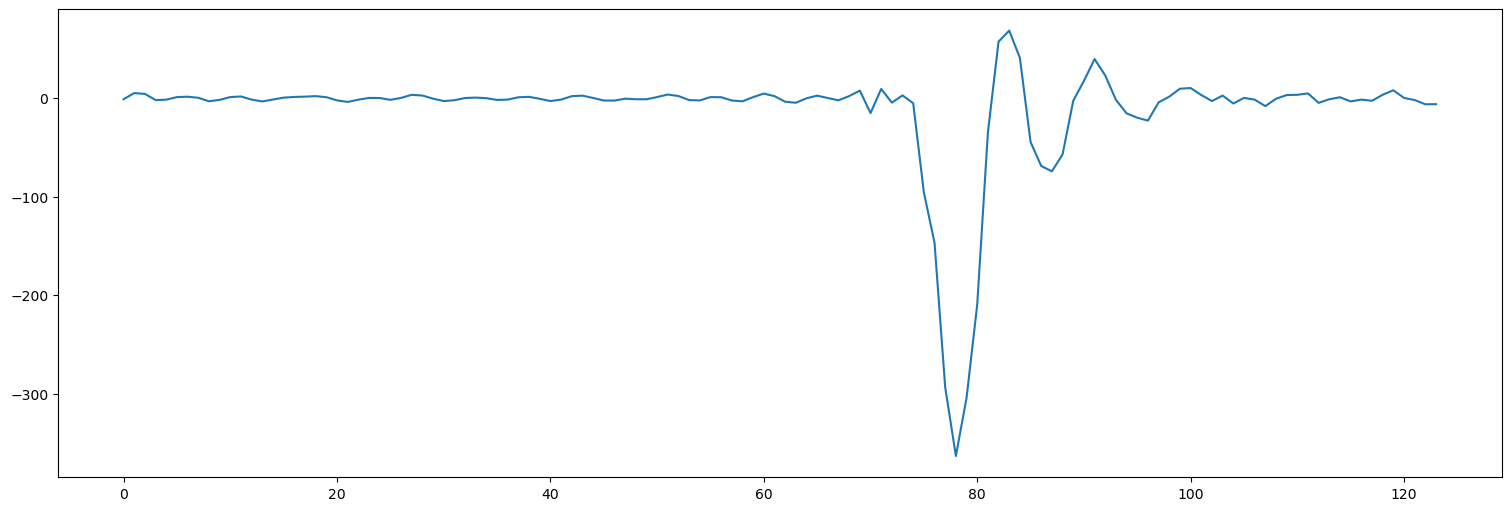

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

frame = int(n_frames/2); print('frame = ', frame)

wave = waveform[frame*n_points: (frame + 1)*n_points].copy()
x_ax = wave[:, 0]

ax.plot(x_ax, wave[:, ch], label = detect[ch])

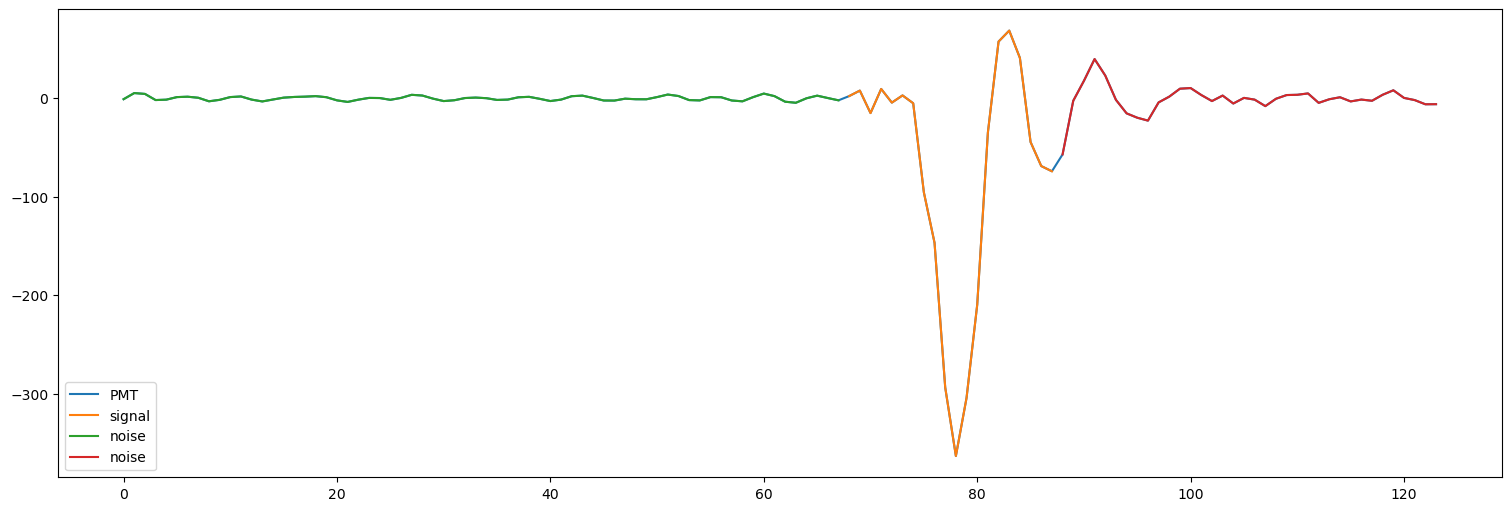

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

t1 = 70
t2 = 90
# t1 = 150
# t2 = 200
# t1 = 0
# t2 = 1000

dt_izq = 10
dt_dch = 10

#_____________________________________________________________________________________________________________

t0 = t1 + int(np.where(wave[:, ch][t1 : t2] == wave[:, ch][t1 : t2].min())[0][0])

pre_base = wave[:, ch][:t0 - dt_izq]
x_ax_pre = x_ax[:t0 - dt_izq]

peak = wave[:, ch][t0 - dt_izq : t0 + dt_dch].copy()
x_ax_peak = x_ax[t0 - dt_izq : t0 + dt_dch].copy()

post_base = wave[:, ch][t0 + dt_dch:]
x_ax_post = x_ax[t0 + dt_dch:]


ax.plot(x_ax, wave[:, ch], label = detect[ch])
ax.plot(x_ax_peak, peak, label='signal')
ax.plot(x_ax_pre, pre_base, label = 'noise')
ax.plot(x_ax_post, post_base, label = 'noise')
ax.legend(loc = 'best')

### Peaks integral with baseline substracted

NOTE: dt_dch is not always the same when taking the signal as when substracting the baseline, since there can be part of the waveform that is not signal neither baseline (like the rebound after the signal in the SiPM). That's why we re-define it after the baseline

In [12]:
# fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

peak_integr = []
peak_integr_pos = []

#______inicio de bucle on frames HERE_______

for frame in range(n_frames):
#     ________________________________________________BASELINE_______________________________________________________

    wave = waveform[frame*n_points: (frame + 1)*n_points].copy()
    x_ax = wave[:, 0]


    t0 = t1 + int(np.where(wave[:, ch][t1 : t2] == wave[:, ch][t1 : t2].min())[0][0])

    pre_base = wave[:, ch][:t0 - dt_izq].copy()
    x_ax_pre = x_ax[:t0 - dt_izq].copy()

    post_base = wave[:, ch][t0 + dt_dch:].copy()
    x_ax_post = x_ax[t0 + dt_dch:].copy()

    base = []
    base.append(pre_base.mean())
    base.append(post_base.mean())

    baseline = np.array(base).mean()
#     print(base, baseline)

    if baseline_corrected:
        wave[:, ch] = wave[:, ch] - baseline # NOW THE WAVEFORM IS CORRECTED



#     ________________________________________________INTEGRAL_______________________________________________________

    
    if integr_method == 'integrate around the peak':
        peak = wave[:, ch][t0 - dt_izq : t0 + dt_dch].copy()
        x_ax_peak = x_ax[t0 - dt_izq : t0 + dt_dch].copy()
    
        control_peak = wave[:, control_ch][t0 - dt_izq : t0 + dt_dch].copy()

        
    if integr_method == 'integrate in a fixed window t1-t2':  
        peak = wave[:, ch][t1 : t2].copy()
        x_ax_peak = x_ax[t1 : t2].copy()
        
        control_peak = wave[:, control_ch][t1 : t2].copy()

            
    if integr_method == 'integrate ALL waveform':
        peak = wave[:, ch].copy()
        x_ax_peak = x_ax.copy()

        control_peak = wave[:, control_ch].copy()


    integr = np.trapz(peak, x=x_ax_peak)
    control_integr = np.trapz(control_peak, x=x_ax_peak)

    peak_integr.append(integr/control_integr)  # normalized to the control PMT
    peak_integr_pos.append([integr, frame])
    
#     print(frame)

peak_integr = np.array(peak_integr)
peak_integr_pos = np.array(peak_integr_pos)

# peak_integr.mean()
# peak_integr
# peak_integr_pos

#_____________________________________plot settings______________________________________________________________

# ax.plot(x_ax, waveform[frame], label = 'calib PMT')
# ax.plot(x_ax_pre, pre_base, label = 'PMT noise')
# ax.plot(x_ax_post, post_base, label = 'PMT noise')
# ax.plot(x_ax, wave, label = 'Leire\'s PMT corrected by baseline')
# ax.plot(x_ax_peak, peak, label='signal')

# ax.set_ylabel('mV')
# ax.set_xlabel('Index')
# ax.set_title('LED pulse at 1.47V, 2us, 5%df')
# ax.text(0.05, .1, 'LED at 992mV, frame %s'%(frame), 
#         transform=ax.transAxes, # to use (x,y) pos with relative values to the axis and not absolute data points
#         fontsize=15, verticalalignment='top', fontfamily='serif',
#         bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))
# ax.legend(loc = 'best')

In [13]:
baseline

-1.3347934013715212

In [14]:
len(peak_integr)
baseline

-1.3347934013715212

### Integrals distribution

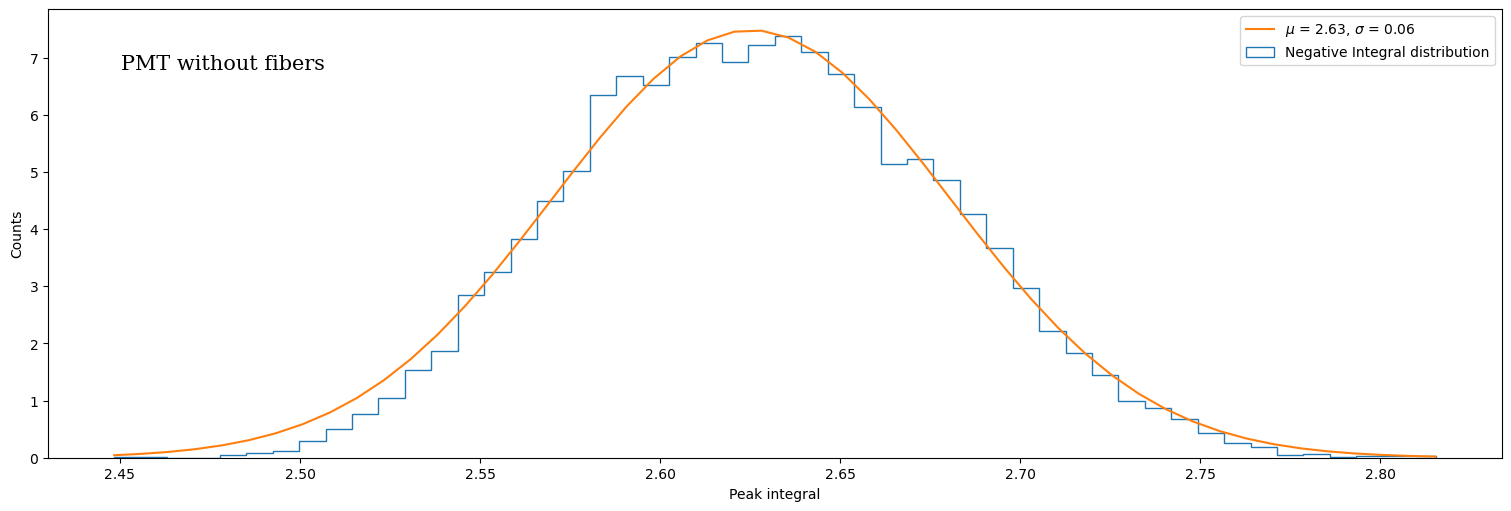

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

# events, bins, bars = plt.hist(peak_integr, 50, density=False, range=(-750, -550), label='Integral distribution')
events, bins, bars = plt.hist(peak_integr, 50, density=True, label='Negative Integral distribution', 
                              histtype='step')
x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)

# # sum of gaussians fit
# popt, pcov = scipy.optimize.curve_fit(gauss_sum, x_ax, events, bounds=([0, -1, 1, 0, -1, 1], 
#                                                                        [np.inf, 1e2, 1e2, np.inf, 1e2, 1e2])) 
# a = np.zeros(n_pe); mu = np.zeros(n_pe); sigma = np.zeros(n_pe)

# a[0], mu[0], sigma[0], a[1], mu[1], sigma[1] = popt
# best_fit_line = gauss_sum(x_ax, a[0], mu[0], sigma[0], a[1], mu[1], sigma[1])

# gaussian fit
# popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, bounds=([0, 0, 1], [np.inf, 3e3, 1e2])) 
popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, bins.mean(), 1e2]) 
    
a, mu, sigma = popt
best_fit_line = gauss(x_ax, a, mu, sigma)

# ax.plot(x_ax, best_fit_line, label='Sum of gaussian fit')
# ax.plot(x_ax, gauss(x_ax, a[0], mu[0], sigma[0]), '-', label='$\mu$ = %.2f, $\sigma$ = %.2f'%(mu[0], sigma[0]))
# ax.plot(x_ax, gauss(x_ax, a[1], mu[1], sigma[1]), '-y', label='$\mu$ = %.2f, $\sigma$ = %.2f'%(mu[1], sigma[1]))
ax.plot(x_ax, gauss(x_ax, a, mu, sigma), '-', label='$\mu$ = %.2f, $\sigma$ = %.2f'%(mu, sigma))

ax.set_ylabel('Counts')
ax.set_xlabel('Peak integral')

ax.text(0.05, .9, detect[ch] + fibers[fib], transform=ax.transAxes,
            fontsize=15, verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

ax.legend(fontsize=10, loc='best')

In [16]:
print(detect[ch] + fibers[fib])
print('Amplification = ', '%.2f'%(a))
print('Mean value = ', '%.2f'%mu)
print('Std = ', '%.2f'%(sigma))

signal[fib] = mu

PMT without fibers
Amplification =  1.04
Mean value =  2.63
Std =  0.06


# With fibers

In [17]:
fib = 1

In [18]:
data = []
with open(filename[fib],'r', encoding='ascii') as fp:
    for i, line in enumerate(fp):
        if any(c.isalpha() for c in line) == False:
            data.append(np.asarray(line.split('\t')[:-1], dtype=float))
fp.close()

waveform = np.array(data)

In [19]:
n_points = int(waveform[:, 0].max() + 1)
n_frames = int(len(waveform)/n_points) 
print('n_frames = ', n_frames)
print('n_points = ', n_points)

n_frames =  12949
n_points =  124


NOTE: the way the data is stored when using only ONE FILE is the following:
- column 0 is just an index (x-axis if you  will), while columns 1, 2, 3 correspond to data from different channels
- each column stores data from MULTIPLE FRAMES
- each frame has n_points points, so in column 0 you can see how after n_points - 1 it resets to 0 when the frame changes

### Waveform

frame =  6474


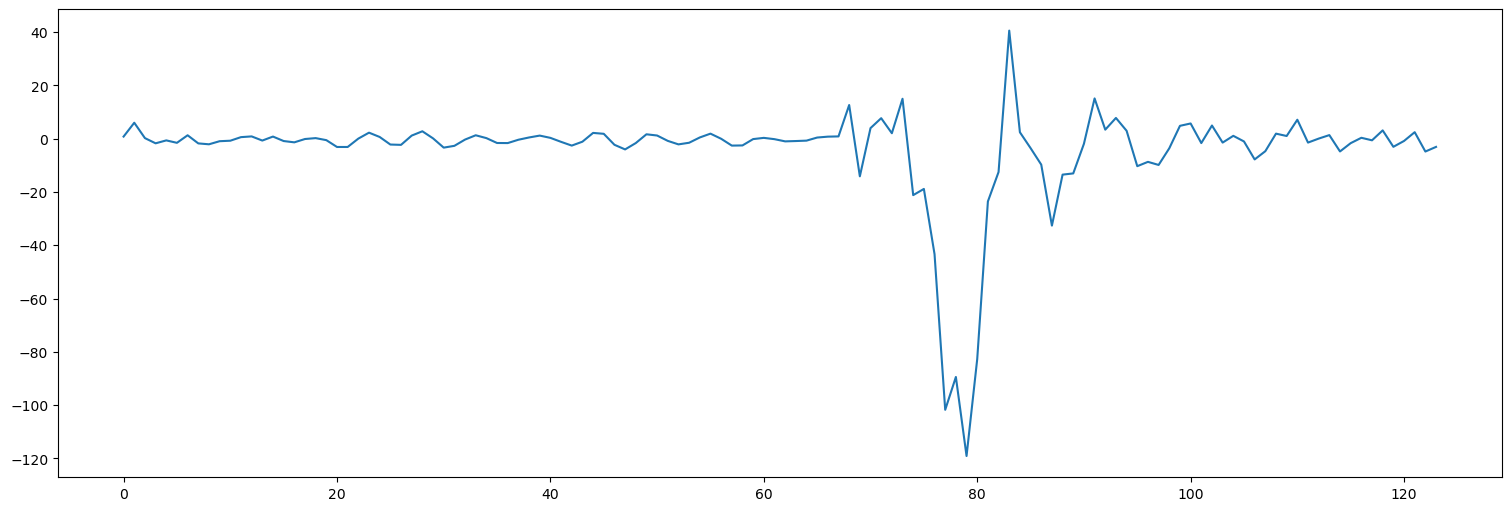

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

frame = int(n_frames/2); print('frame = ', frame)

wave = waveform[frame*n_points: (frame + 1)*n_points].copy()
x_ax = wave[:, 0]

ax.plot(x_ax, wave[:, ch], label = detect[ch])

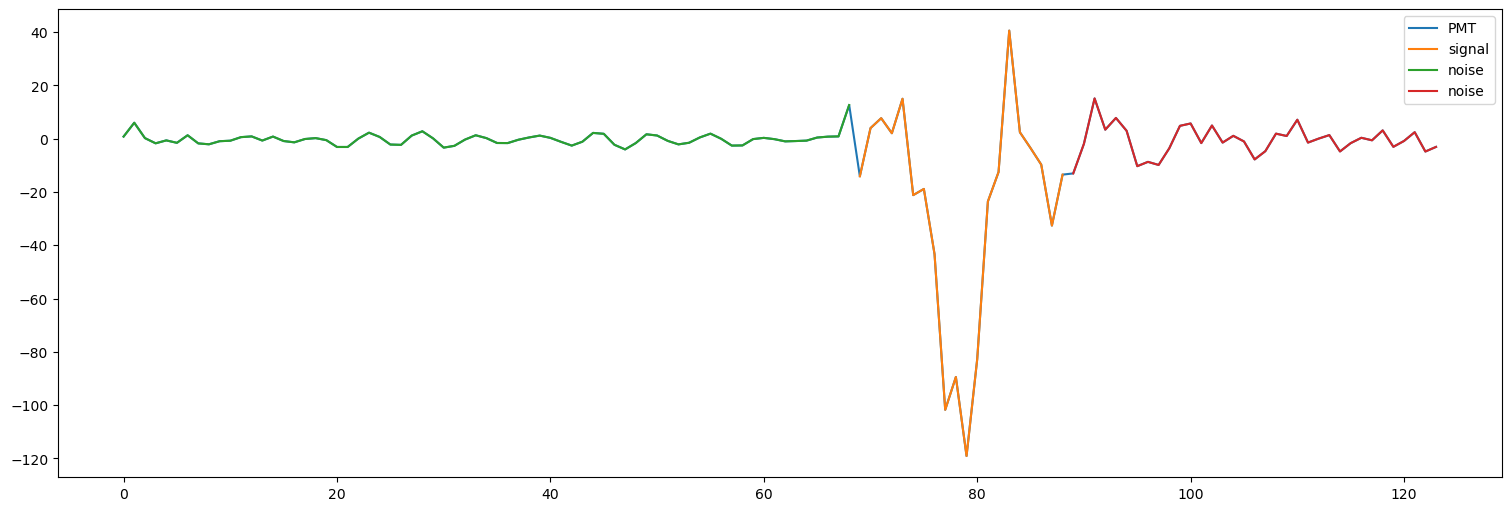

In [21]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

t1 = 70
t2 = 90
# t1 = 150
# t2 = 200
# t1 = 0
# t2 = 1000

dt_izq = 10
dt_dch = 10

#_____________________________________________________________________________________________________________

t0 = t1 + int(np.where(wave[:, ch][t1 : t2] == wave[:, ch][t1 : t2].min())[0][0])

pre_base = wave[:, ch][:t0 - dt_izq]
x_ax_pre = x_ax[:t0 - dt_izq]

peak = wave[:, ch][t0 - dt_izq : t0 + dt_dch].copy()
x_ax_peak = x_ax[t0 - dt_izq : t0 + dt_dch].copy()

post_base = wave[:, ch][t0 + dt_dch:]
x_ax_post = x_ax[t0 + dt_dch:]


ax.plot(x_ax, wave[:, ch], label = detect[ch])
ax.plot(x_ax_peak, peak, label='signal')
ax.plot(x_ax_pre, pre_base, label = 'noise')
ax.plot(x_ax_post, post_base, label = 'noise')
ax.legend(loc = 'best')

### Peaks integral with baseline substracted

NOTE: dt_dch is not always the same when taking the signal as when substracting the baseline, since there can be part of the waveform that is not signal neither baseline (like the rebound after the signal in the SiPM). That's why we re-define it after the baseline

In [22]:
# fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

peak_integr = []
peak_integr_pos = []

#______inicio de bucle on frames HERE_______

for frame in range(n_frames):
#     ________________________________________________BASELINE_______________________________________________________

    wave = waveform[frame*n_points: (frame + 1)*n_points].copy()
    x_ax = wave[:, 0]


    t0 = t1 + int(np.where(wave[:, ch][t1 : t2] == wave[:, ch][t1 : t2].min())[0][0])

    pre_base = wave[:, ch][:t0 - dt_izq].copy()
    x_ax_pre = x_ax[:t0 - dt_izq].copy()

    post_base = wave[:, ch][t0 + dt_dch:].copy()
    x_ax_post = x_ax[t0 + dt_dch:].copy()

    base = []
    base.append(pre_base.mean())
    base.append(post_base.mean())

    baseline = np.array(base).mean()
#     print(base, baseline)
    
    if baseline_corrected:
        wave[:, ch] = wave[:, ch] - baseline # NOW THE WAVEFORM IS CORRECTED



#     ________________________________________________INTEGRAL_______________________________________________________

    if integr_method == 'integrate around the peak':
        peak = wave[:, ch][t0 - dt_izq : t0 + dt_dch].copy()
        x_ax_peak = x_ax[t0 - dt_izq : t0 + dt_dch].copy()
        
        control_peak = wave[:, control_ch][t0 - dt_izq : t0 + dt_dch].copy()
    
    
    if integr_method == 'integrate in a fixed window t1-t2':  
        peak = wave[:, ch][t1 : t2].copy()
        x_ax_peak = x_ax[t1 : t2].copy()
        
        control_peak = wave[:, control_ch][t1 : t2].copy()


    if integr_method == 'integrate ALL waveform':
        peak = wave[:, ch].copy()
        x_ax_peak = x_ax.copy()

        control_peak = wave[:, control_ch].copy()
    

    integr = np.trapz(peak, x=x_ax_peak)
    control_integr = np.trapz(control_peak, x=x_ax_peak)

    peak_integr.append(integr/control_integr) # normalized to control PMT
    peak_integr_pos.append([integr, frame])
    
#     print(frame)

peak_integr = np.array(peak_integr)
peak_integr_pos = np.array(peak_integr_pos)

# peak_integr.mean()
# peak_integr
# peak_integr_pos

#_____________________________________plot settings______________________________________________________________

# ax.plot(x_ax, waveform[frame], label = 'calib PMT')
# ax.plot(x_ax_pre, pre_base, label = 'PMT noise')
# ax.plot(x_ax_post, post_base, label = 'PMT noise')
# ax.plot(x_ax, wave, label = 'Leire\'s PMT corrected by baseline')
# ax.plot(x_ax_peak, peak, label='signal')

# ax.set_ylabel('mV')
# ax.set_xlabel('Index')
# ax.set_title('LED pulse at 1.47V, 2us, 5%df')
# ax.text(0.05, .1, 'LED at 992mV, frame %s'%(frame), 
#         transform=ax.transAxes, # to use (x,y) pos with relative values to the axis and not absolute data points
#         fontsize=15, verticalalignment='top', fontfamily='serif',
#         bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))
# ax.legend(loc = 'best')

In [23]:
len(peak_integr)
baseline

-0.45732066376811575

### Integrals distribution

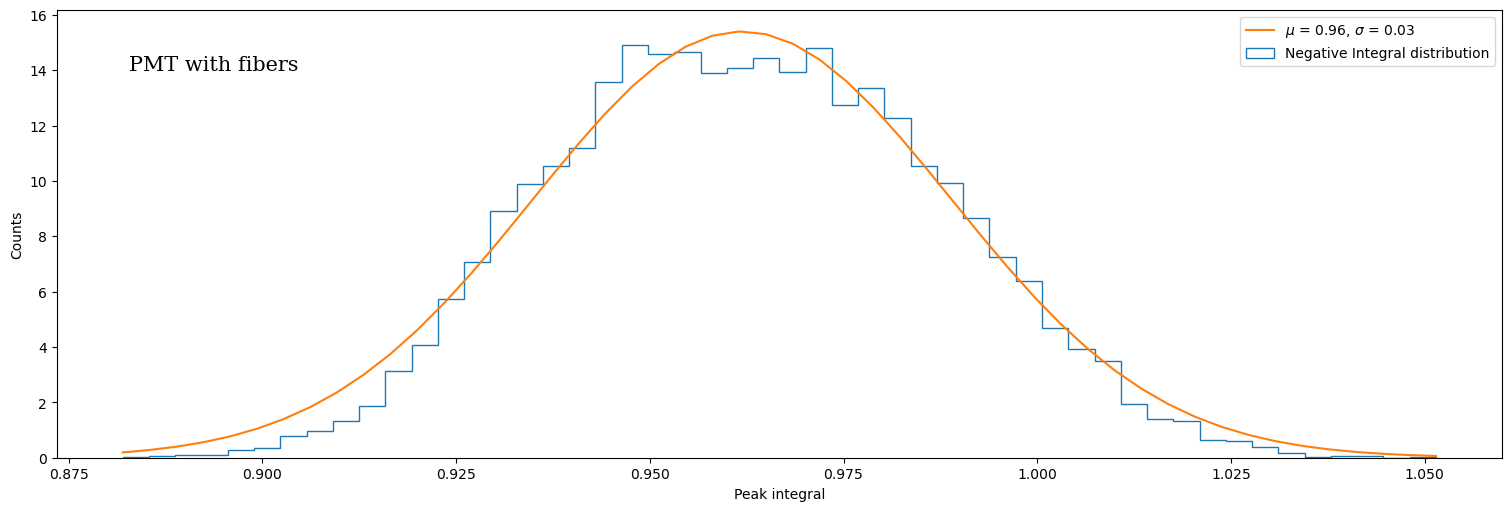

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

# events, bins, bars = plt.hist(peak_integr, 50, density=False, range=(-750, -550), label='Integral distribution')
events, bins, bars = plt.hist(peak_integr, 50, density=True, label='Negative Integral distribution', 
                              histtype='step')
x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)


# # sum of gaussians fit
# popt, pcov = scipy.optimize.curve_fit(gauss_sum, x_ax, events, bounds=([0, -1, 1, 0, -1, 1], 
#                                                                        [np.inf, 1e2, 1e2, np.inf, 1e2, 1e2])) 
# a = np.zeros(n_pe); mu = np.zeros(n_pe); sigma = np.zeros(n_pe)

# a[0], mu[0], sigma[0], a[1], mu[1], sigma[1] = popt
# best_fit_line = gauss_sum(x_ax, a[0], mu[0], sigma[0], a[1], mu[1], sigma[1])


# gaussian fit
# popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, bounds=([0, 0, 1], [np.inf, 3e3, 1e2])) 
popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, bins.mean(), 1e2]) 
    
a, mu, sigma = popt
best_fit_line = gauss(x_ax, a, mu, sigma)

# ax.plot(x_ax, best_fit_line, label='Sum of gaussian fit')
# ax.plot(x_ax, gauss(x_ax, a[0], mu[0], sigma[0]), '-', label='$\mu$ = %.2f, $\sigma$ = %.2f'%(mu[0], sigma[0]))
# ax.plot(x_ax, gauss(x_ax, a[1], mu[1], sigma[1]), '-y', label='$\mu$ = %.2f, $\sigma$ = %.2f'%(mu[1], sigma[1]))
ax.plot(x_ax, gauss(x_ax, a, mu, sigma), '-', label='$\mu$ = %.2f, $\sigma$ = %.2f'%(mu, sigma))

ax.set_ylabel('Counts')
ax.set_xlabel('Peak integral')

ax.text(0.05, .9, detect[ch] + fibers[fib], transform=ax.transAxes,
            fontsize=15, verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

ax.legend(fontsize=10, loc='best')

In [25]:
print(detect[ch] + fibers[fib])
print('Amplification = ', '%.2f'%(a))
print('Mean value = ', '%.2f'%mu)
print('Std = ', '%.2f'%(sigma))

signal[fib] = mu

PMT with fibers
Amplification =  1.04
Mean value =  0.96
Std =  0.03


# Efficiency

In [26]:
QE = {'LED':0.13, 'Y11':0.18} # Quantum efficiency without and with fibers
fib_area = 36*36
pmt_area = 18*18

n_photon_led = signal[0]/(QE['LED']*pmt_area)
n_photon_fib = signal[1]/(QE['Y11']*fib_area)


eff = QE['Y11']*n_photon_fib/n_photon_led

In [27]:
print(detect[ch] + ' with fibers efficiency = %.2f %%'%(eff*100))
print('Baseline corrected:', baseline_corrected)
print('Integration method:', integr_method)

PMT with fibers efficiency = 1.19 %
Baseline corrected: False
Integration method: integrate ALL waveform


# Timer

In [28]:
tf = time.perf_counter()
print('Code timer: %.2f'%(tf-t0))

Code timer: 28428.45
